In [1]:
%reload_ext autoreload
%autoreload 2
import logging
log = lambda msg: logging.info(msg)
import os
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Full pipeline (single file)

In [15]:
#input_file = "C:\\dev\\play\\brainwave-data\\2024-07-15-22-33-27\\raw.fif"
# input_file = "C:\\dev\\play\\brainwave-data\\2024-07-15-22-33-27\\raw.fif"
input_file = "C:\\dev\\play\\brainwave-data\\2024-09-13-21-24-32\\raw.fif"
input_file_without_ext = os.path.splitext(input_file)[0]
input_file_brainwave = "C:\\dev\\play\\brainwave-data\\2024-09-13-21-24-32.brainflow.csv"


In [16]:
channels = ['Fpz-M1']
import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

restored_data = DataFilter.read_file(input_file_brainwave)
log("Finished reading Brainflow file")
board_id = BoardIds.CYTON_BOARD.value


restored_df = pd.DataFrame(np.transpose(restored_data))

eeg_channels = BoardShim.get_eeg_channels(board_id)

log(f"EEG channels: {eeg_channels}")

selected_columns = [restored_df.columns[0]]
num_eeg_channels_to_select = min(len(eeg_channels), len(channels))
selected_eeg_channels = [eeg_channels[i] for i in range(num_eeg_channels_to_select)]
selected_columns.extend(selected_eeg_channels)
selected_columns.append(restored_df.columns[-2])
idx_and_eeg_channels_and_timestamp = restored_df[selected_columns]

column_names = ['sampleIdx'] + channels + ['timestamp']
idx_and_eeg_channels_and_timestamp.columns = column_names
idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')

eeg_channels_only = idx_and_eeg_channels_and_timestamp[channels]


# Brainflow Cyton data in uV, MNE expects V
scaled = eeg_channels_only / 1_000_000

ch_types = ['eeg'] * len(channels)

initial_timestamp = idx_and_eeg_channels_and_timestamp['datetime'].iloc[0]

2024-09-16 18:18:49,988 - INFO - Finished reading Brainflow file
2024-09-16 18:18:50,010 - INFO - EEG channels: [1, 2, 3, 4, 5, 6, 7, 8]
C:\Users\graha\AppData\Local\Temp\ipykernel_39008\3589198258.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')


In [37]:
last_timestamp = idx_and_eeg_channels_and_timestamp['datetime'].iloc[-1]
last_timestamp

Timestamp('2024-09-14 05:57:07.233875036+0000', tz='UTC')

In [39]:
idx_and_eeg_channels_and_timestamp

,sampleIdx,Fpz,timestamp,datetime
0,0.0,1439.631157,1.726259e+09,2024-09-13 20:24:33.024538040+00:00
1,1.0,1315.601327,1.726259e+09,2024-09-13 20:24:33.024589062+00:00
2,2.0,1291.416739,1.726259e+09,2024-09-13 20:24:33.024616003+00:00
3,3.0,1337.707202,1.726259e+09,2024-09-13 20:24:33.024641037+00:00
4,4.0,1409.813930,1.726259e+09,2024-09-13 20:24:33.024665117+00:00
...,...,...,...,...
8377502,174.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233815908+00:00
8377503,175.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233830929+00:00
8377504,176.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233845949+00:00
8377505,177.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233860016+00:00


In [51]:
idx_and_eeg_channels_and_timestamp['epoch_ms'] = idx_and_eeg_channels_and_timestamp['datetime'].astype('int64') / 1000
idx_and_eeg_channels_and_timestamp['time_diff_ms'] = idx_and_eeg_channels_and_timestamp['datetime'].diff().dt.total_seconds() * 1000
idx_and_eeg_channels_and_timestamp['epoch_diff_ms'] = idx_and_eeg_channels_and_timestamp['epoch_ms'].diff()
idx_and_eeg_channels_and_timestamp['expected_next'] = idx_and_eeg_channels_and_timestamp['datetime'] + pd.Timedelta(seconds=1/250, unit='s')
idx_and_eeg_channels_and_timestamp

C:\Users\graha\AppData\Local\Temp\ipykernel_39008\57259444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['epoch_ms'] = idx_and_eeg_channels_and_timestamp['datetime'].astype('int64') / 1000
C:\Users\graha\AppData\Local\Temp\ipykernel_39008\57259444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['time_diff_ms'] = idx_and_eeg_channels_and_timestamp['datetime'].diff().dt.total_seconds() * 1000
C:\Users\graha\AppData\Local\Temp\ipyk

,sampleIdx,Fpz,timestamp,datetime,expected_next,time_diff_ms,epoch_ms,epoch_diff_ms,epoch_us
0,0.0,1439.631157,1.726259e+09,2024-09-13 20:24:33.024538040+00:00,2024-09-13 20:24:33.028538040+00:00,NaN,1.726259e+15,NaN,-7734869904159811904
1,1.0,1315.601327,1.726259e+09,2024-09-13 20:24:33.024589062+00:00,2024-09-13 20:24:33.028589062+00:00,0.051022,1.726259e+15,51.00,-7734869904108789904
2,2.0,1291.416739,1.726259e+09,2024-09-13 20:24:33.024616003+00:00,2024-09-13 20:24:33.028616003+00:00,0.026941,1.726259e+15,27.00,-7734869904081848904
3,3.0,1337.707202,1.726259e+09,2024-09-13 20:24:33.024641037+00:00,2024-09-13 20:24:33.028641037+00:00,0.025034,1.726259e+15,25.00,-7734869904056814904
4,4.0,1409.813930,1.726259e+09,2024-09-13 20:24:33.024665117+00:00,2024-09-13 20:24:33.028665117+00:00,0.024080,1.726259e+15,24.00,-7734869904032734904
...,...,...,...,...,...,...,...,...,...
8377502,174.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233815908+00:00,2024-09-14 05:57:07.237815908+00:00,0.015020,1.726293e+15,14.75,-7700515694881943904
8377503,175.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233830929+00:00,2024-09-14 05:57:07.237830929+00:00,0.015021,1.726293e+15,15.25,-7700515694866922904
8377504,176.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233845949+00:00,2024-09-14 05:57:07.237845949+00:00,0.015020,1.726293e+15,15.00,-7700515694851902904
8377505,177.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233860016+00:00,2024-09-14 05:57:07.237860016+00:00,0.014067,1.726293e+15,14.00,-7700515694837835904


In [38]:
import pandas as pd
import numpy as np
df = idx_and_eeg_channels_and_timestamp
# Assuming `df` is your DataFrame and `sfreq` is your sampling frequency
initial_timestamp = df['datetime'].iloc[0]
last_timestamp = df['datetime'].iloc[-1]
sfreq = 250  # Example sampling frequency in Hz

# Generate expected timestamps
expected_times = pd.date_range(start=initial_timestamp, end=last_timestamp, freq=pd.Timedelta(seconds=1/sfreq), tz='UTC')

# Find missing timestamps
actual_times = df['datetime']
missing_times = expected_times.difference(actual_times)

# Create a DataFrame for missing timestamps with 0 as the sample value
missing_df = pd.DataFrame({'datetime': missing_times, 'sample': 0})

# Concatenate the original DataFrame with the missing DataFrame
df_with_missing = pd.concat([df, missing_df]).sort_values(by='datetime').reset_index(drop=True)

df_with_missing

,sampleIdx,Fpz,timestamp,datetime,sample
0,0.0,1439.631157,1.726259e+09,2024-09-13 20:24:33.024538040+00:00,NaN
1,1.0,1315.601327,1.726259e+09,2024-09-13 20:24:33.024589062+00:00,NaN
2,2.0,1291.416739,1.726259e+09,2024-09-13 20:24:33.024616003+00:00,NaN
3,3.0,1337.707202,1.726259e+09,2024-09-13 20:24:33.024641037+00:00,NaN
4,4.0,1409.813930,1.726259e+09,2024-09-13 20:24:33.024665117+00:00,NaN
...,...,...,...,...,...
16966038,174.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233815908+00:00,NaN
16966039,175.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233830929+00:00,NaN
16966040,176.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233845949+00:00,NaN
16966041,177.0,-187500.022352,1.726293e+09,2024-09-14 05:57:07.233860016+00:00,NaN


In [30]:
restored_df['datetime'].dt.floor('min').drop_duplicates()

0         2024-09-13 20:24:00+00:00
6742      2024-09-13 20:25:00+00:00
21762     2024-09-13 20:26:00+00:00
36738     2024-09-13 20:27:00+00:00
51754     2024-09-13 20:28:00+00:00
                     ...           
8315589   2024-09-14 05:53:00+00:00
8330622   2024-09-14 05:54:00+00:00
8345641   2024-09-14 05:55:00+00:00
8360660   2024-09-14 05:56:00+00:00
8375689   2024-09-14 05:57:00+00:00
Name: datetime, Length: 564, dtype: datetime64[ns, UTC]

In [22]:
restored_df['datetime'] = pd.to_datetime(restored_df[22],unit="s").dt.tz_localize('UTC')
restored_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,datetime
0,0.0,1439.631157,-102045.727020,-187500.022352,-64749.740332,-106917.647352,-187500.022352,-187500.022352,-174035.219733,0.054,...,3.0,0.0,15.0,64.0,0.0,0.0,0.0,1.726259e+09,0.0,2024-09-13 20:24:33.024538040+00:00
1,1.0,1315.601327,-102053.952462,-187500.022352,-64752.489597,-106924.263468,-187500.022352,-187500.022352,-174060.097225,0.054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726259e+09,0.0,2024-09-13 20:24:33.024589062+00:00
2,2.0,1291.416739,-102008.466662,-187500.022352,-64686.551951,-106864.651366,-187500.022352,-187500.022352,-174028.357748,0.054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726259e+09,0.0,2024-09-13 20:24:33.024616003+00:00
3,3.0,1337.707202,-101976.883647,-187500.022352,-64625.866965,-106822.227755,-187500.022352,-187500.022352,-174003.010869,0.054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726259e+09,0.0,2024-09-13 20:24:33.024641037+00:00
4,4.0,1409.813930,-102068.548151,-187500.022352,-64695.894980,-106917.937925,-187500.022352,-187500.022352,-174100.911510,0.054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726259e+09,0.0,2024-09-13 20:24:33.024665117+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8377502,174.0,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-0.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726293e+09,0.0,2024-09-14 05:57:07.233815908+00:00
8377503,175.0,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-0.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726293e+09,0.0,2024-09-14 05:57:07.233830929+00:00
8377504,176.0,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-0.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726293e+09,0.0,2024-09-14 05:57:07.233845949+00:00
8377505,177.0,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-187500.022352,-0.102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.726293e+09,0.0,2024-09-14 05:57:07.233860016+00:00


In [29]:
sfreq = 250
expected_times_raw = np.arange(len(restored_df)) / sfreq
expected_times_raw
# expected_times = pd.DataFrame(expected_times_raw, columns=['datetime'])
# expected_times['datetime'] = pd.to_timedelta(expected_times['datetime'], unit='s') + initial_timestamp
# expected_times
# merged_times = expected_times.merge(restored_df, on='datetime', how='left', indicator=True)
# missing_times_df = merged_times[merged_times['_merge'] == 'left_only']
# missing_times_df

array([0.0000000e+00, 4.0000000e-03, 8.0000000e-03, ..., 3.3510016e+04,
       3.3510020e+04, 3.3510024e+04])

In [31]:
import convert

log("Loading MNE file " + input_file)
raw, input_file_without_ext, mne_filtered = convert.load_mne_file(log, input_file)


2024-09-16 18:36:00,128 - INFO - Loading MNE file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif
2024-09-16 18:36:00,129 - INFO - Reading file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif


Opening raw data file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif...
Isotrak not found
    Range : 0 ... 8377506 =      0.000 ... 33510.024 secs
Ready.
Reading 0 ... 8377506  =      0.000 ... 33510.024 secs...


2024-09-16 18:36:01,802 - INFO - Padded missing times from (8377507,) to (8377507,), (1, 8377507) to (1, 8377507)


Creating RawArray with float64 data, n_channels=1, n_times=8377507
    Range : 0 ... 8377506 =      0.000 ... 33510.024 secs
Ready.


2024-09-16 18:36:01,825 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2751 samples (11.004 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



In [35]:
times = pd.DataFrame(raw.times, columns=['datetime'])
times['delta'] = pd.to_timedelta(times['datetime'], unit='s')
start = pd.to_datetime(raw.info['meas_date'])
times['pd_datetime'] = start + times['delta']
times['pd_datetime'].dt.floor('min').drop_duplicates()

0         2024-09-13 20:24:00+00:00
6744      2024-09-13 20:25:00+00:00
21744     2024-09-13 20:26:00+00:00
36744     2024-09-13 20:27:00+00:00
51744     2024-09-13 20:28:00+00:00
                     ...           
8316744   2024-09-14 05:39:00+00:00
8331744   2024-09-14 05:40:00+00:00
8346744   2024-09-14 05:41:00+00:00
8361744   2024-09-14 05:42:00+00:00
8376744   2024-09-14 05:43:00+00:00
Name: pd_datetime, Length: 560, dtype: datetime64[ns, UTC]

In [19]:
import missing_data
times, unique_timestamps, expected_times, merged_times, missing_times_df = missing_data.times_data(raw)
display(times.iloc[0])
display(times.iloc[4000000])
display(times.iloc[8377506])
display(len(times))
display(times.head())

datetime                                    0.0
delta                           0 days 00:00:00
pd_datetime    2024-09-13 20:24:33.024538+00:00
minute                2024-09-13 20:24:00+00:00
Name: 0, dtype: object

datetime                                16000.0
delta                           0 days 04:26:40
pd_datetime    2024-09-14 00:51:13.024538+00:00
minute                2024-09-14 00:51:00+00:00
Name: 4000000, dtype: object

datetime                              33510.024
delta                    0 days 09:18:30.024000
pd_datetime    2024-09-14 05:43:03.048538+00:00
minute                2024-09-14 05:43:00+00:00
Name: 8377506, dtype: object

8377507

,datetime,delta,pd_datetime,minute
0,0.000,0 days 00:00:00,2024-09-13 20:24:33.024538+00:00,2024-09-13 20:24:00+00:00
1,0.004,0 days 00:00:00.004000,2024-09-13 20:24:33.028538+00:00,2024-09-13 20:24:00+00:00
2,0.008,0 days 00:00:00.008000,2024-09-13 20:24:33.032538+00:00,2024-09-13 20:24:00+00:00
3,0.012,0 days 00:00:00.012000,2024-09-13 20:24:33.036538+00:00,2024-09-13 20:24:00+00:00
4,0.016,0 days 00:00:00.016000,2024-09-13 20:24:33.040538+00:00,2024-09-13 20:24:00+00:00


In [11]:
unique_timestamps

,minute
0,2024-09-15 20:14:00+00:00
13605,2024-09-15 20:15:00+00:00
28605,2024-09-15 20:16:00+00:00
43605,2024-09-15 20:17:00+00:00
58605,2024-09-15 20:18:00+00:00
...,...
9913605,2024-09-16 07:15:00+00:00
9928605,2024-09-16 07:16:00+00:00
9943605,2024-09-16 07:17:00+00:00
9958605,2024-09-16 07:18:00+00:00


In [10]:
missing_times_df

,datetime,delta,pd_datetime,_merge


In [79]:
len(times)

8377507

In [21]:
import mne
raw = mne.io.read_raw_fif(input_file, preload=True)
raw.times.shape


Opening raw data file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif...
Isotrak not found
    Range : 0 ... 8377506 =      0.000 ... 33510.024 secs
Ready.
Reading 0 ... 8377506  =      0.000 ... 33510.024 secs...


(8377507,)

In [62]:
display(raw.times.shape)
display(raw.get_data().shape)

(8377507,)

(1, 8377507)

In [54]:
import missing_data
times, unique_timestamps, expected_times, missing_times = missing_data.times_data_numpy(raw)


In [60]:
missing_times

array([], dtype=float64)

In [51]:
import pandas as pd
times = pd.DataFrame(raw.times, columns=['datetime'])
# start = pd.to_datetime(raw.info['meas_date'])
# start_timedelta = pd.to_timedelta(start - pd.Timestamp('1970-01-01', tz='UTC'))
# times['pd_datetime'] = pd.to_datetime(times['datetime'], unit='ms', origin='unix', utc=True) + start_timedelta


In [52]:
times

,datetime
0,0.000
1,0.004
2,0.008
3,0.012
4,0.016
...,...
8377502,33510.008
8377503,33510.012
8377504,33510.016
8377505,33510.020


In [47]:
times['minute']

0         2024-09-13 20:24:00+00:00
1         2024-09-13 20:24:00+00:00
2         2024-09-13 20:24:00+00:00
3         2024-09-13 20:24:00+00:00
4         2024-09-13 20:24:00+00:00
                     ...           
8377502   2024-09-13 20:25:00+00:00
8377503   2024-09-13 20:25:00+00:00
8377504   2024-09-13 20:25:00+00:00
8377505   2024-09-13 20:25:00+00:00
8377506   2024-09-13 20:25:00+00:00
Name: minute, dtype: datetime64[ns, UTC]

In [48]:
times

,datetime,pd_datetime,minute
0,0.000,2024-09-13 20:24:33.024538+00:00,2024-09-13 20:24:00+00:00
1,0.004,2024-09-13 20:24:33.024542+00:00,2024-09-13 20:24:00+00:00
2,0.008,2024-09-13 20:24:33.024546+00:00,2024-09-13 20:24:00+00:00
3,0.012,2024-09-13 20:24:33.024550+00:00,2024-09-13 20:24:00+00:00
4,0.016,2024-09-13 20:24:33.024554+00:00,2024-09-13 20:24:00+00:00
...,...,...,...
8377502,33510.008,2024-09-13 20:25:06.534546+00:00,2024-09-13 20:25:00+00:00
8377503,33510.012,2024-09-13 20:25:06.534550+00:00,2024-09-13 20:25:00+00:00
8377504,33510.016,2024-09-13 20:25:06.534554+00:00,2024-09-13 20:25:00+00:00
8377505,33510.020,2024-09-13 20:25:06.534558+00:00,2024-09-13 20:25:00+00:00


In [42]:
pd.set_option('display.max_rows', 10)  # Set the maximum number of rows to display
pd.set_option('display.max_columns', 10)  # Set the maximum number of columns to display
pd.set_option('display.show_dimensions', False)  # Hide the dimensions of the DataFrame
pd.set_option('display.max_colwidth', None)  # Ensure columns are not truncated


times

,datetime,pd_datetime,minute
0,0.000,2024-09-13 20:24:33.024538+00:00,2024-09-13 20:24:00+00:00
1,0.004,2024-09-13 20:24:33.024542+00:00,2024-09-13 20:24:00+00:00
2,0.008,2024-09-13 20:24:33.024546+00:00,2024-09-13 20:24:00+00:00
3,0.012,2024-09-13 20:24:33.024550+00:00,2024-09-13 20:24:00+00:00
4,0.016,2024-09-13 20:24:33.024554+00:00,2024-09-13 20:24:00+00:00
...,...,...,...
8377502,33510.008,2024-09-13 20:25:06.534546+00:00,2024-09-13 20:25:00+00:00
8377503,33510.012,2024-09-13 20:25:06.534550+00:00,2024-09-13 20:25:00+00:00
8377504,33510.016,2024-09-13 20:25:06.534554+00:00,2024-09-13 20:25:00+00:00
8377505,33510.020,2024-09-13 20:25:06.534558+00:00,2024-09-13 20:25:00+00:00


In [44]:
pd.set_option('display.max_rows', 10)  # Set the maximum number of rows to display
pd.set_option('display.show_dimensions', False)  # Hide the dimensions of the DataFrame

unique_timestamps

,minute
0,2024-09-13 20:24:00+00:00
6743866,2024-09-13 20:25:00+00:00


In [16]:
from missing_data import zero_missing_times

zeroed = zero_missing_times(log, raw)


2024-09-16 08:50:20,756 - INFO - Padded missing times from (8377507,) to (8377507,), (1, 8377507) to (1, 8377507)


Creating RawArray with float64 data, n_channels=1, n_times=8377507
    Range : 0 ... 8377506 =      0.000 ... 33510.024 secs
Ready.


In [19]:
zeroed.times.shape

(8377507,)

In [20]:
raw.times.shape

(8377507,)

In [24]:
import numpy as np
import mne

# Assuming `raw` is your MNE RawArray object
sfreq = raw.info['sfreq']  # Sampling frequency
n_samples = raw.n_times  # Number of samples

# Generate expected times
expected_times = np.arange(n_samples) / sfreq

# Get actual times from the RawArray
actual_times = raw.times

# Find missing times
missing_times = np.setdiff1d(expected_times, actual_times)
missing_times


array([], dtype=float64)

In [25]:
expected_times.shape

(8377507,)

In [ ]:
    # Load MNE

channels = raw.info['ch_names']
sfreq = raw.info['sfreq']
start_date = raw.info['meas_date']
# Hardcoded fixes for some borked files
if (start_date.year < 2000):
    date_time_str = os.path.basename(os.path.dirname(input_file))

    # Parse the date and time string into a datetime object
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')

    # Set the timezone to UK time
    uk_timezone = pytz.timezone('Europe/London')
    date_time_uk = uk_timezone.localize(date_time_obj)
    date_time_utc = date_time_uk.astimezone(timezone.utc)

    log(f"Have tried to fix broken startdate in {input_file} from {start_date} to {date_time_utc}")
    start_date = date_time_utc
    mne_filtered.set_meas_date(start_date)
    raw.set_meas_date(start_date)
end_date = start_date + timedelta(seconds=float(raw.times[-1]))

# Save as EDF
garbage_collect(log)
log("Saving as EDF")
convert.save_mne_as_downsample_edf(log, mne_filtered, input_file_without_ext)

# Sleep events
garbage_collect(log)
log("Loading sleep events")
ha_events = sleep_events.load_sleep_events(log, start_date, end_date, waking_start_time_tz, waking_end_time_tz)
output_csv_file = input_file_without_ext + ".night_events.csv"
ha_events.to_csv(output_csv_file, index=False)

# YASA features
garbage_collect(log)
log("Extracting YASA features")
yasa_feats, channel_feats_dict = yasa_features.extract_yasa_features2(log, channels, mne_filtered)

# YASA slow waves
garbage_collect(log)
log("Detecting slow waves")
sw = sw_detect(mne_filtered, sfreq)
if sw is not None:
    sw_summary = sw.summary()
    output_csv_file = input_file_without_ext + ".sw_summary.csv"
    sw_summary.to_csv(output_csv_file, index=False)

# YASA spindles
# Too intensive for Pi
# garbage_collect(log)
# log("Detecting spindles")
# sp = spindles_detect(mne_filtered, sfreq)
# if sp is not None:
#     sp_summary = sp.summary()
#     output_csv_file = input_file_without_ext + ".spindle_summary.csv"
#     sp_summary.to_csv(output_csv_file, index=False)

# YASA proper
garbage_collect(log)
log("Running YASA")
yasa_copy, json_out = run_yasa.run_yasa_report(log, input_file_without_ext, raw, False)

# Combine epochs and YASA features
garbage_collect(log)
df = yasa_copy.copy()
df['epoch'] = df['Epoch']
df.set_index('epoch', inplace=True)
combined_df = df.join(yasa_feats)

# Automated waking scoring
# We're training a model to more accurately predict waking than YASA.  So we have to be judicious in what YASA data we use - while being aware that manually scoring waking is challenging.  So only use data where YASA is supremely confident in wakefulness.
garbage_collect(log)
log("Automated waking scoring")
df_probably_awake = wakings.get_yasa_probably_awake(log, combined_df)

# Manual waking scoring
garbage_collect(log)
log("Manual waking scoring")
df_definitely_awake = wakings.get_definitely_awake(df_probably_awake, ha_events, waking_start_time_tz, waking_end_time_tz)

# Combine probably and definitely awake
df_combined_awake = df_probably_awake.copy()
df_combined_awake['DefinitelyAwake'] = df_definitely_awake['DefinitelyAwake']
df_combined_awake['ProbablyAwake'] = (df_combined_awake['DefinitelyAwake'] == True) | (df_combined_awake['YASAProbablyAwake'] == True)

# Epochs that are probably sleep
garbage_collect(log)
log("Epochs that are probably sleep")
df_asleep = sleep.probably_asleep(df_combined_awake)

# Remvoe when YASA-esque model restored
output_csv_file = input_file_without_ext + ".with_features.csv"
df_asleep.to_csv(output_csv_file, index=False)

# Run current best YASAesque model
# Skipping as seems to require Fpz
# log("Running YASAesque model")
# df_with_predictions = best_model.run_model(df_asleep)
# output_csv_file = input_file_without_ext + ".with_features.csv"
# df_with_predictions.to_csv(output_csv_file, index=False)

# Run current best microwakings model
garbage_collect(log)
log("Running microwakings model")
try:
    microwakings_model = microwakings1.load_model()
    pf = PerFile(None, mne_filtered, yasa_copy, input_file_without_ext)
    pf.prepare_model_data(microwakings1.RESAMPLING_RATE, False)
    microwakings1.predict_file(log, microwakings_model, pf)
except Exception as e:
    log("Error running microwakings model: " + str(e))
    log(traceback.format_exc())
    raise e

log("All done! " + input_file)


In [9]:
brainflow_input_file = "C:\\dev\\play\\brainwave-data\\2024-09-13-21-24-32.brainflow.csv"

import mne
import numpy as np
import pandas as pd
from brainflow import BoardIds, DataFilter, BoardShim

board_id = BoardIds.CYTON_BOARD.value
channels = ['Fpz-M1']

log(f"Reading Brainflow file {brainflow_input_file}")
restored_data = DataFilter.read_file(brainflow_input_file)
log("Finished reading Brainflow file")

restored_df = pd.DataFrame(np.transpose(restored_data))

eeg_channels = BoardShim.get_eeg_channels(board_id)

log(f"EEG channels: {eeg_channels}")



2024-09-14 13:17:43,228 - INFO - Reading Brainflow file C:\dev\play\brainwave-data\2024-09-13-21-24-32.brainflow.csv
2024-09-14 13:20:43,394 - INFO - Finished reading Brainflow file
2024-09-14 13:20:43,418 - INFO - EEG channels: [1, 2, 3, 4, 5, 6, 7, 8]
C:\Users\graha\AppData\Local\Temp\ipykernel_31228\1593869361.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')
2024-09-14 13:20:47,040 - INFO - Initial timestamp: 2024-09-13 20:24:33.024538040+00:00 from 1726259073.024538


In [10]:
selected_columns = [restored_df.columns[0]]
num_eeg_channels_to_select = min(len(eeg_channels), len(channels))
selected_eeg_channels = [eeg_channels[i] for i in range(num_eeg_channels_to_select)]
selected_columns.extend(selected_eeg_channels)
selected_columns.append(restored_df.columns[-2])
idx_and_eeg_channels_and_timestamp = restored_df[selected_columns]

column_names = ['sampleIdx'] + channels + ['timestamp']
idx_and_eeg_channels_and_timestamp.columns = column_names
idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')

eeg_channels_only = idx_and_eeg_channels_and_timestamp[channels]


# Brainflow Cyton data in uV, MNE expects V
scaled = eeg_channels_only / 1_000_000

ch_types = ['eeg'] * len(channels)

initial_timestamp = idx_and_eeg_channels_and_timestamp['datetime'].iloc[0]
log(f"Initial timestamp: {str(initial_timestamp)} from {idx_and_eeg_channels_and_timestamp['timestamp'].iloc[0]}")

sfreq = BoardShim.get_sampling_rate(board_id)
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=ch_types)
info.set_meas_date(initial_timestamp)
toSave = mne.io.RawArray(np.transpose(scaled), info)


C:\Users\graha\AppData\Local\Temp\ipykernel_31228\2621432458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')
2024-09-14 13:20:56,519 - INFO - Initial timestamp: 2024-09-13 20:24:33.024538040+00:00 from 1726259073.024538


In [17]:
import numpy as np
import mne

# Assuming `raw` is your MNE RawArray object
raw = toSave
sfreq = raw.info['sfreq']  # Sampling frequency
n_samples = raw.n_times  # Number of samples

# Generate expected times
expected_times = np.arange(n_samples) / sfreq

# Get actual times from the RawArray
actual_times = raw.times

# Find missing times
missing_times = np.setdiff1d(expected_times, actual_times)

print(f"Missing times: {missing_times}")

Missing times: []


In [19]:
idx_and_eeg_channels_and_timestamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8377507 entries, 0 to 8377506
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   sampleIdx  float64            
 1   Fpz        float64            
 2   timestamp  float64            
 3   datetime   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 255.7 MB


In [23]:
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame
df = idx_and_eeg_channels_and_timestamp

# Extract the datetime column
actual_times = df['datetime']

# Generate expected times based on the sampling frequency
sfreq = 250  # Example sampling frequency in Hz
n_samples = len(df)
expected_times = pd.date_range(start=actual_times.iloc[0], periods=n_samples, freq=pd.Timedelta(seconds=1/sfreq), tz='UTC')

# Find missing times
missing_times = expected_times.difference(actual_times)

print(f"Missing times: {missing_times}")

Missing times: DatetimeIndex(['2024-09-13 20:24:33.028538040+00:00',
               '2024-09-13 20:24:33.032538040+00:00',
               '2024-09-13 20:24:33.036538040+00:00',
               '2024-09-13 20:24:33.040538040+00:00',
               '2024-09-13 20:24:33.044538040+00:00',
               '2024-09-13 20:24:33.048538040+00:00',
               '2024-09-13 20:24:33.052538040+00:00',
               '2024-09-13 20:24:33.056538040+00:00',
               '2024-09-13 20:24:33.060538040+00:00',
               '2024-09-13 20:24:33.064538040+00:00',
               ...
               '2024-09-14 05:43:03.012538040+00:00',
               '2024-09-14 05:43:03.016538040+00:00',
               '2024-09-14 05:43:03.020538040+00:00',
               '2024-09-14 05:43:03.024538040+00:00',
               '2024-09-14 05:43:03.028538040+00:00',
               '2024-09-14 05:43:03.032538040+00:00',
               '2024-09-14 05:43:03.036538040+00:00',
               '2024-09-14 05:43:03.040538040+00

In [28]:
df['minute'] = df['datetime'].dt.floor('T')

# Drop duplicates
unique_minutes = df['minute'].drop_duplicates()

# Convert back to DataFrame
unique_timestamps = pd.DataFrame(unique_minutes)

# Display the DataFrame without ellipses
pd.set_option('display.max_rows', None)
unique_timestamps

C:\Users\graha\AppData\Local\Temp\ipykernel_31228\3186893484.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
C:\Users\graha\AppData\Local\Temp\ipykernel_31228\3186893484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df['datetime'].dt.floor('T')


,minute
0,2024-09-13 20:24:00+00:00
6742,2024-09-13 20:25:00+00:00
21762,2024-09-13 20:26:00+00:00
36738,2024-09-13 20:27:00+00:00
51754,2024-09-13 20:28:00+00:00
66784,2024-09-13 20:29:00+00:00
81812,2024-09-13 20:30:00+00:00
96842,2024-09-13 20:31:00+00:00
111857,2024-09-13 20:32:00+00:00
126876,2024-09-13 20:33:00+00:00


In [59]:
times = pd.DataFrame(raw.times)

,0
0,0.000
1,0.004
2,0.008
3,0.012
4,0.016


In [57]:
raw.times[1]

0.004

In [58]:
times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8377507 entries, 0 to 8377506
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
dtypes: float64(1)
memory usage: 63.9 MB


In [45]:
raw.info['meas_date']

Timestamp('2024-09-13 20:24:33.024538040+0000', tz='UTC')

In [75]:
t = raw.times
d = raw.get_data(units='uV')


In [76]:

# Generate expected times based on the sampling frequency
sfreq = raw.info['sfreq']  # Sampling frequency
n_samples = raw.n_times  # Number of samples
expected_times = np.arange(n_samples) / sfreq


In [77]:

# Find missing times
missing_times = np.setdiff1d(expected_times, t)

In [78]:

# Create a new array for `d` with the same shape as `d`, initializing it with zeros
new_d = np.zeros((d.shape[0], len(expected_times)))

# Copy the original values of `d` into the new array at the positions where `t` is not missing
for i, time in enumerate(expected_times):
    if time in t:
        new_d[:, i] = d[:, np.where(t == time)[0][0]]


KeyboardInterrupt: 

In [79]:
import numpy as np

# Assuming `raw` is your MNE RawArray object
t = raw.times
d = raw.get_data(units='uV')

# Generate expected times based on the sampling frequency
sfreq = raw.info['sfreq']  # Sampling frequency
n_samples = raw.n_times  # Number of samples
expected_times = np.arange(n_samples) / sfreq

# Create a mask for the missing times
mask = np.isin(expected_times, t)

# Create a new array for `d` with the same shape as `d`, initializing it with zeros
new_d = np.zeros((d.shape[0], len(expected_times)))

# Copy the original values of `d` into the new array at the positions where `t` is not missing
new_d[:, mask] = d

# Now `new_d` contains 0 wherever `t` had a missing value
print(new_d)

[[   1439.631157    1315.601327    1291.416739 ... -187500.022352
  -187500.022352 -187500.022352]]


In [74]:
import numpy as np

# Assuming `raw` is your MNE RawArray object


# Now `new_d` contains 0 wherever `t` had a missing value
#print(new_d)

KeyboardInterrupt: 

In [64]:
len(raw.times)

8377507

In [66]:
times = pd.DataFrame(raw.times)
len(times)


8377507

In [26]:
missing_data.times_data(raw)
# times = pd.DataFrame(raw.times)
# display(times.head())
# 
# 
# times.rename(columns={0: 'datetime'}, inplace=True)
# # times['datetime_secs'] = times['datetime'] / 1000
# 
# 
# # Ensure the column is of datetime type
# 
# 
# start = pd.to_datetime(raw.info['meas_date'])
# start_timedelta = pd.to_timedelta(start - pd.Timestamp('1970-01-01', tz='UTC'))
# 
# times['pd_datetime'] = pd.to_datetime(times['datetime'], unit='ms', origin='unix', utc=True) + start_timedelta
# # times['datetime_from_start'] = times['pd_datetime'] + start_timedelta
# 
# print(times.head())
# 
# times['minute'] = times['pd_datetime'].dt.floor('min')
# display(times.head())
# 
# # 
# # # Drop duplicates
# unique_minutes = times['minute'].drop_duplicates()
# 
# # Convert back to DataFrame
# unique_timestamps = pd.DataFrame(unique_minutes)
# 
# # Display the DataFrame without ellipses
# pd.set_option('display.max_rows', None)
# unique_timestamps


,0
0,0.000
1,0.004
2,0.008
3,0.012
4,0.016


   datetime                      pd_datetime
0     0.000 2024-09-13 20:24:33.024538+00:00
1     0.004 2024-09-13 20:24:33.024542+00:00
2     0.008 2024-09-13 20:24:33.024546+00:00
3     0.012 2024-09-13 20:24:33.024550+00:00
4     0.016 2024-09-13 20:24:33.024554+00:00


,datetime,pd_datetime,minute
0,0.000,2024-09-13 20:24:33.024538+00:00,2024-09-13 20:24:00+00:00
1,0.004,2024-09-13 20:24:33.024542+00:00,2024-09-13 20:24:00+00:00
2,0.008,2024-09-13 20:24:33.024546+00:00,2024-09-13 20:24:00+00:00
3,0.012,2024-09-13 20:24:33.024550+00:00,2024-09-13 20:24:00+00:00
4,0.016,2024-09-13 20:24:33.024554+00:00,2024-09-13 20:24:00+00:00


,minute
0,2024-09-13 20:24:00+00:00
6743866,2024-09-13 20:25:00+00:00


In [54]:
times.head()

,datetime,pd_datetime,minute,datetime_from_start
0,0.000,2024-09-13 20:24:33.024538040,2024-09-13 20:24:00,2024-09-13 20:24:33.024538040
1,0.004,2024-09-13 20:24:33.024538040,2024-09-13 20:24:00,2024-09-13 20:24:33.024538040
2,0.008,2024-09-13 20:24:33.024538040,2024-09-13 20:24:00,2024-09-13 20:24:33.024538040
3,0.012,2024-09-13 20:24:33.024538040,2024-09-13 20:24:00,2024-09-13 20:24:33.024538040
4,0.016,2024-09-13 20:24:33.024538040,2024-09-13 20:24:00,2024-09-13 20:24:33.024538040


In [4]:
import tensorflow as tf
tf.version.VERSION


'2.10.1'

In [5]:
from datetime import timedelta, datetime
import pytz

# start_date = datetime.strptime("2024-08-26", "%Y-%m-%d")
# waking_start_time = (start_date + timedelta(days=1)).replace(hour=0, minute=9)
# waking_end_time = (start_date + timedelta(days=1)).replace(hour=1, minute=19)
# waking_start_time = waking_start_time.astimezone(pytz.UTC)
# waking_end_time = waking_end_time.astimezone(pytz.UTC)

waking_start_time = None
waking_end_time = None

2024-09-14 12:16:27,379 - INFO - Loading MNE file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif
2024-09-14 12:16:27,380 - INFO - Reading file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif
2024-09-14 12:16:27,970 - INFO - Finished reading file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif
2024-09-14 12:16:29,831 - INFO - Memory Usage: 641.53 MB GC to 641.53 MB
2024-09-14 12:16:29,832 - INFO - Saving as EDF
2024-09-14 12:16:32,673 - INFO - Memory Usage: 736.30 MB GC to 736.30 MB
2024-09-14 12:16:32,674 - INFO - Loading sleep events
C:\dev\play\brainwave-processor\sleep_events.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ha_events_for_file = ha_events[ha_events['timestamp'] >= start_date][ha_events['timestamp'] <= end_date][ha_events['event'] == 'wake']
C:\dev\play\brainwave-processor\sleep_events.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ha_events_for_file = ha_events[ha_events['

Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 1.60 Hz)
- Filter length: 4125 samples (16.500 s)



2024-09-14 12:16:37,332 - INFO - Memory Usage: 880.82 MB GC to 880.82 MB
2024-09-14 12:16:37,334 - INFO - Running YASA
2024-09-14 12:16:37,565 - INFO - Memory Usage: 880.82 MB GC to 880.82 MB
2024-09-14 12:16:42,557 - WARNING - Hypnogram is SHORTER than data by 0.03 seconds. Padding hypnogram with last value to match data.size.
2024-09-14 12:17:09,815 - INFO - Writing to C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.sleep_stages.csv
2024-09-14 12:17:10,335 - INFO - Memory Usage: 1080.52 MB GC to 1080.52 MB
2024-09-14 12:17:10,339 - INFO - Processing sleep statistics
2024-09-14 12:17:10,783 - INFO - Memory Usage: 1080.52 MB GC to 1080.52 MB
2024-09-14 12:17:10,786 - INFO - Processing sleep stability
2024-09-14 12:17:11,171 - INFO - Memory Usage: 1080.52 MB GC to 1080.52 MB


Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 1.60 Hz)
- Filter length: 4125 samples (16.500 s)



2024-09-14 12:17:38,741 - INFO - Memory Usage: 1124.29 MB GC to 1090.22 MB
2024-09-14 12:17:38,750 - INFO - YASA all done!
2024-09-14 12:17:39,299 - INFO - Memory Usage: 1026.30 MB GC to 1026.30 MB
2024-09-14 12:17:39,763 - INFO - Memory Usage: 1026.30 MB GC to 1026.30 MB
2024-09-14 12:17:39,766 - INFO - Automated waking scoring
2024-09-14 12:17:40,361 - INFO - Memory Usage: 1026.38 MB GC to 1026.38 MB
2024-09-14 12:17:40,363 - INFO - Manual waking scoring
2024-09-14 12:17:42,241 - INFO - Memory Usage: 1026.42 MB GC to 1026.42 MB
2024-09-14 12:17:42,246 - INFO - Epochs that are probably sleep
2024-09-14 12:17:42,955 - INFO - All done! C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif


,Stage,Confidence,Epoch,Timestamp,Source,Fpz_Stage,Fpz_Confidence,StageInt,Fpz_eeg_abspow,Fpz_eeg_abspow_c7min_norm,...,Fpz_eeg_std,Fpz_eeg_std_c7min_norm,Fpz_eeg_std_p2min_norm,Fpz_eeg_theta,Fpz_eeg_theta_c7min_norm,Fpz_eeg_theta_p2min_norm,YASAProbablyAwake,DefinitelyAwake,ProbablyAwake,ProbablySleep
epoch,,,,,,,,,,,,,,,,,,,,,
0,W,0.998170,0,2024-09-13 21:24:33.024538040+01:00,Fpz,W,0.998170,0,2.566076e-09,0.704100,...,8.365574e-05,0.295934,0.267552,0.083475,-0.045591,-0.088650,False,False,False,False
1,W,0.996149,1,2024-09-13 21:25:03.024538040+01:00,Fpz,W,0.996149,0,3.171461e-09,0.688023,...,7.193461e-05,0.296836,0.239720,0.106006,-0.023439,-0.006128,True,False,True,False
2,W,0.998641,2,2024-09-13 21:25:33.024538040+01:00,Fpz,W,0.998641,0,1.551707e-09,0.652373,...,5.246215e-05,0.294186,0.199617,0.095510,-0.011084,-0.004250,True,False,True,False
3,W,0.998347,3,2024-09-13 21:26:03.024538040+01:00,Fpz,W,0.998347,0,1.131621e-09,0.627323,...,8.298659e-05,0.296144,0.215806,0.085477,0.003461,-0.021684,True,False,True,False
4,W,0.997858,4,2024-09-13 21:26:33.024538040+01:00,Fpz,W,0.997858,0,2.713326e-09,0.609899,...,6.952017e-05,0.292986,0.199024,0.105548,0.014981,0.018738,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,W,0.998835,1112,2024-09-14 06:40:33.024538040+01:00,Fpz,W,0.998835,0,3.131795e-34,15256.854492,...,2.214025e-17,56.614834,85.932571,0.113369,0.262967,-0.221159,True,False,True,False
1113,W,0.999018,1113,2024-09-14 06:41:03.024538040+01:00,Fpz,W,0.999018,0,1.128952e-34,14044.560547,...,1.420801e-17,51.548618,85.659416,0.266334,0.417205,0.134509,True,False,True,False
1114,W,0.998189,1114,2024-09-14 06:41:33.024538040+01:00,Fpz,W,0.998189,0,1.255873e-34,12896.373047,...,1.252719e-17,46.699642,77.188980,0.152779,0.550960,0.278440,True,False,True,False


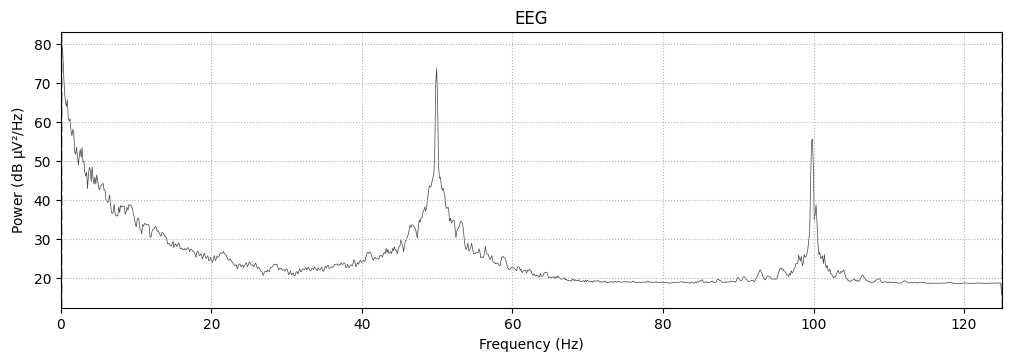

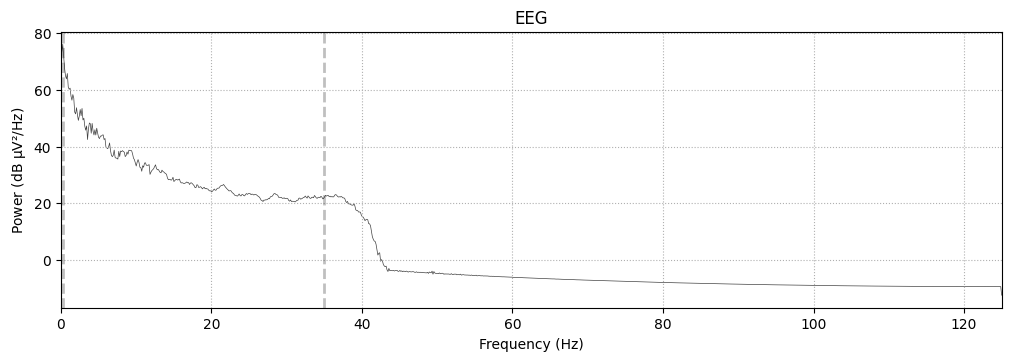

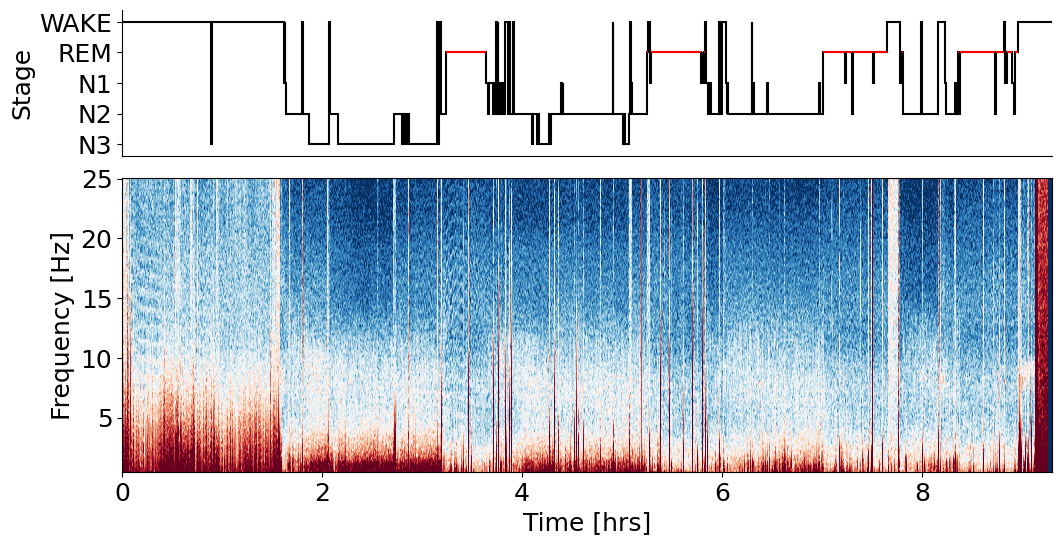

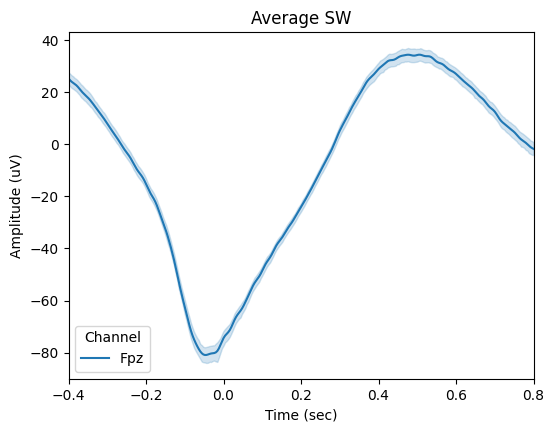

In [6]:
import run_feature_pipeline
# df = run_feature_pipeline.cached_pipeline(log, input_file)
df = run_feature_pipeline.pipeline(log, input_file)
df

In [7]:
from upload import upload_dir_to_gcs_skipping_existing

full_dir_name = os.path.dirname(input_file)
dir_name = os.path.basename(full_dir_name)
display(full_dir_name)
display(dir_name)
upload_dir_to_gcs_skipping_existing(log, 'examined-life-derived-eeg', full_dir_name, dir_name)

'C:\\dev\\play\\brainwave-data\\2024-09-01-21-11-15'

'2024-09-01-21-11-15'

2024-09-14 07:40:58,088 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.average_slow_wave.png uploading to 2024-09-01-21-11-15/raw.average_slow_wave.png
2024-09-14 07:40:58,717 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.edf uploading to 2024-09-01-21-11-15/raw.edf
2024-09-14 07:41:12,159 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.fif uploading to 2024-09-01-21-11-15/raw.fif
2024-09-14 07:41:41,122 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.manual_sleep_scoring_model.pkl uploading to 2024-09-01-21-11-15/raw.manual_sleep_scoring_model.pkl
2024-09-14 07:41:42,757 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.microwakings.csv uploading to 2024-09-01-21-11-15/raw.microwakings.csv
2024-09-14 07:41:42,861 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.night_events.csv uploading to 2024-09-01-21-11-15/raw.night_events.csv
2024-09-14 07:41:42,980 - INFO - C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.

# Testing potential pipeline enhancements